In [437]:
import random
from tqdm import tqdm

import torch
import torchvision
import torch.optim as optim
from torchvision import transforms
from torch import nn
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#import os

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
#torch.manual_seed(SEED)
#torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [438]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


## Долгая функция

In [439]:
DIR = 'data'
CLASS = {'Cars':0, 'Drones': 1, 'People':2}

list_of_file = []   # filename/details
list_of_img = []    # x
list_of_classi = [] # y

for root, dirs, files in os.walk(DIR):
    for file in files:
        if file.endswith('.csv'):
            tmp = root.strip().split('\\')
            if tmp[-2] in CLASS:
                list_of_classi.append(CLASS[tmp[-2]])
                list_of_file.append(os.path.join('/'.join(tmp[-3:]),file))
                df = pd.read_csv(os.path.join(root,file), sep=',',header=None)
                list_of_img.append(df.values)

x = np.array(list_of_img)
y = np.array(list_of_classi)
d = np.array(list_of_file)
                
print(len(list_of_file), 'files loaded.')

17485 files loaded.


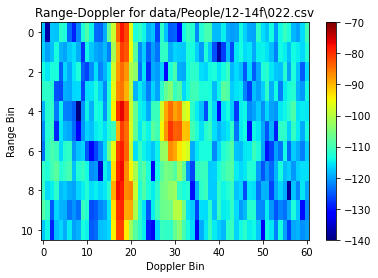

In [440]:
fig = plt.figure()
ax = plt.axes()
img = ax.imshow(list_of_img[12802], vmin=-140, vmax=-70, cmap='jet')
plt.title('Range-Doppler for {}'.format(list_of_file[12800]))
plt.axis('tight')
plt.ylabel('Range Bin')
plt.xlabel('Doppler Bin')
plt.colorbar(img)
plt.show()

In [441]:
x = np.power(10, x/10)
x = x/np.max(x)

In [480]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [481]:
a = torch.Tensor(X_train)
X_train = torch.unsqueeze(a, 1)
y_train = torch.Tensor(y_train).cuda().long()

b = torch.Tensor(X_test)
X_test = torch.unsqueeze(b, 1)
y_test = torch.Tensor(y_test).cuda().long()

print(X_train.shape, X_test.shape)

torch.Size([13988, 1, 11, 61]) torch.Size([3497, 1, 11, 61])


In [482]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)    

batch = 16
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch)
val_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=batch)

In [483]:
def train_one_epoch(model, train_dataloader, criterion, optimizer, epoch_index, device="cuda:0"):
    model.to(device)
    model.train()
    
    running_loss = 0
    num = 0
    res_loss = []
    for x_, y_ in tqdm(train_dataloader):
        x_train, y_train = x_.to(device), y_.to(device) # перенос вычислений на GPU
        
        y_pred = model(x_train) # делаем предсказание
        
        loss = criterion(y_pred, y_train) 
        loss.backward()
        optimizer.step() # делаем шаг SGD
        optimizer.zero_grad() # зануляем градиенты
        
        running_loss += loss.item()
        res_loss.append(loss.item())
        num += 1
        if num % 250 == 249:    # 
            #print(f'[{epoch_index}, {num + 1:5d}] loss: {running_loss / 250:.3f}')
            running_loss = 0.0
    return np.mean(res_loss)

def predict(model, val_dataloader, criterion, device="cuda:0"):
    model.to(device)
    model.eval()
    losses = []
    true_classes = []
    predicted_classes = []
    total = 0
    correct = 0
    with torch.no_grad():
        for x_, y_ in tqdm(val_dataloader):
            x_test, y_test = x_.to(device), y_.to(device) # перенос вычислений на GPU           
            y_pred = model(x_test)
            loss = criterion(y_pred, y_test)
            losses.append(loss.item())
            
            _, predicted = torch.max(y_pred.data, 1)
            predicted_classes.extend(predicted.cpu().numpy().tolist())
            true_classes.extend(y_test.cpu().numpy().tolist())
            
            total += y_test.size(0)
            correct += (predicted == y_test).sum().item()
       
    return np.mean(losses), predicted_classes, true_classes


def train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler=None, device="cuda:0", n_epochs=10):
    model.to(device)
    best_acc = 0
    for epoch in (range(1, n_epochs+1)):
        # YOUR CODE
        train_loss = train_one_epoch(model, train_dataloader, criterion, optimizer, epoch, device="cuda:0")
        if True or epoch % 2 == 1: 
            valid_loss, predicted, true = predict(model, val_dataloader, criterion, device="cuda:0")
            accuracy = accuracy_score(predicted, true)
            print(f"Эпоха: {epoch};\t train loss: {train_loss:.3f};\t valid loss: {valid_loss:.3f};\t Точность: {100 * accuracy:.2f} %")
            if best_acc < accuracy:
                best_acc = accuracy
                torch.save(model, "model/BomjNet_best.pth")
                torch.save(model.state_dict(), "model/BomjNet_best_w.pt")
        if scheduler != None:
            scheduler.step()

In [496]:
class Net(nn.Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16992, 4096),
            #nn.BatchNorm1d(64),
            nn.ReLU(),
            
            nn.Linear(4096, 1024), 
            #nn.BatchNorm1d(64),
            nn.ReLU(),
            
            nn.Linear(1024, 64), 
            #nn.BatchNorm1d(64),
            nn.ReLU(),

            nn.Linear(64, 3),
            nn.Softmax(dim=1)
                        
        )

         # Антецедент распространения
    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.linear_layers(x)
        return x


In [497]:
model = Net()
model.cuda()

n_epochs = 50
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, eps=1e-08)

criterion = nn.CrossEntropyLoss()

scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.97)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

In [498]:
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
#assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(predicted_labels, true_labels)
print("tests passed")
print(accuracy)
print(len(true_labels), len(val_dataset))

100%|██████████| 219/219 [00:00<00:00, 247.21it/s]

tests passed
0.33543036888761796
3497 1749


In [499]:
# SEED = 42

# random.seed(SEED)
# np.random.seed(SEED)
# torch.manual_seed(SEED)
# torch.cuda.manual_seed(SEED)
# torch.backends.cudnn.deterministic = True


torch.cuda.empty_cache()
train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, device, n_epochs)

100%|██████████| 219/219 [00:00<00:00, 371.92it/s]


Эпоха: 1;	 train loss: 0.877;	 valid loss: 1.132;	 Точность: 41.98 %


100%|██████████| 219/219 [00:00<00:00, 364.51it/s]


Эпоха: 2;	 train loss: 0.801;	 valid loss: 1.120;	 Точность: 43.09 %


100%|██████████| 219/219 [00:00<00:00, 360.80it/s]


Эпоха: 3;	 train loss: 0.787;	 valid loss: 1.147;	 Точность: 40.43 %


100%|██████████| 219/219 [00:00<00:00, 358.44it/s]


Эпоха: 4;	 train loss: 0.773;	 valid loss: 1.118;	 Точность: 43.32 %


100%|██████████| 219/219 [00:00<00:00, 366.26it/s]


Эпоха: 5;	 train loss: 0.763;	 valid loss: 1.141;	 Точность: 41.01 %


100%|██████████| 219/219 [00:00<00:00, 358.45it/s]


Эпоха: 6;	 train loss: 0.756;	 valid loss: 1.005;	 Точность: 54.68 %


100%|██████████| 219/219 [00:00<00:00, 366.26it/s]


Эпоха: 7;	 train loss: 0.749;	 valid loss: 1.111;	 Точность: 44.07 %


100%|██████████| 219/219 [00:00<00:00, 359.64it/s]


Эпоха: 8;	 train loss: 0.750;	 valid loss: 0.892;	 Точность: 65.89 %


100%|██████████| 219/219 [00:00<00:00, 365.59it/s]


Эпоха: 9;	 train loss: 0.740;	 valid loss: 0.904;	 Точность: 64.05 %


100%|██████████| 219/219 [00:00<00:00, 360.45it/s]


Эпоха: 10;	 train loss: 0.736;	 valid loss: 0.980;	 Точность: 57.16 %


100%|██████████| 219/219 [00:00<00:00, 361.98it/s]


Эпоха: 11;	 train loss: 0.737;	 valid loss: 0.824;	 Точность: 72.40 %


100%|██████████| 219/219 [00:00<00:00, 363.78it/s]


Эпоха: 12;	 train loss: 0.730;	 valid loss: 1.062;	 Точность: 48.93 %


100%|██████████| 219/219 [00:00<00:00, 355.87it/s]


Эпоха: 13;	 train loss: 0.728;	 valid loss: 1.088;	 Точность: 46.38 %


100%|██████████| 219/219 [00:00<00:00, 367.44it/s]


Эпоха: 14;	 train loss: 0.727;	 valid loss: 0.888;	 Точность: 66.14 %


100%|██████████| 219/219 [00:00<00:00, 342.72it/s]


Эпоха: 15;	 train loss: 0.727;	 valid loss: 1.090;	 Точность: 46.13 %


100%|██████████| 219/219 [00:00<00:00, 336.46it/s]


Эпоха: 16;	 train loss: 0.721;	 valid loss: 0.898;	 Точность: 64.40 %


100%|██████████| 219/219 [00:00<00:00, 359.57it/s]


Эпоха: 17;	 train loss: 0.721;	 valid loss: 0.906;	 Точность: 63.20 %


100%|██████████| 219/219 [00:00<00:00, 360.34it/s]


Эпоха: 18;	 train loss: 0.716;	 valid loss: 1.066;	 Точность: 48.58 %


100%|██████████| 219/219 [00:00<00:00, 360.20it/s]


Эпоха: 19;	 train loss: 0.715;	 valid loss: 0.806;	 Точность: 74.29 %


100%|██████████| 219/219 [00:00<00:00, 361.93it/s]


Эпоха: 20;	 train loss: 0.714;	 valid loss: 0.806;	 Точность: 74.52 %


100%|██████████| 219/219 [00:00<00:00, 361.36it/s]


Эпоха: 21;	 train loss: 0.716;	 valid loss: 1.027;	 Точность: 52.44 %


100%|██████████| 219/219 [00:00<00:00, 339.51it/s]


Эпоха: 22;	 train loss: 0.713;	 valid loss: 1.090;	 Точность: 46.24 %


100%|██████████| 219/219 [00:00<00:00, 367.81it/s]


Эпоха: 23;	 train loss: 0.706;	 valid loss: 0.914;	 Точность: 63.77 %


100%|██████████| 219/219 [00:00<00:00, 368.00it/s]


Эпоха: 24;	 train loss: 0.706;	 valid loss: 0.905;	 Точность: 64.74 %


100%|██████████| 219/219 [00:00<00:00, 357.84it/s]


Эпоха: 25;	 train loss: 0.706;	 valid loss: 1.063;	 Точность: 48.81 %


100%|██████████| 219/219 [00:00<00:00, 365.63it/s]


Эпоха: 26;	 train loss: 0.703;	 valid loss: 1.120;	 Точность: 43.09 %


100%|██████████| 219/219 [00:00<00:00, 369.98it/s]


Эпоха: 27;	 train loss: 0.703;	 valid loss: 1.052;	 Точность: 49.93 %


100%|██████████| 219/219 [00:00<00:00, 356.72it/s]


Эпоха: 28;	 train loss: 0.702;	 valid loss: 1.071;	 Точность: 48.10 %


100%|██████████| 219/219 [00:00<00:00, 354.94it/s]


Эпоха: 29;	 train loss: 0.701;	 valid loss: 0.923;	 Точность: 60.34 %


100%|██████████| 219/219 [00:00<00:00, 357.93it/s]


Эпоха: 30;	 train loss: 0.701;	 valid loss: 1.111;	 Точность: 44.04 %


100%|██████████| 219/219 [00:00<00:00, 354.37it/s]


Эпоха: 31;	 train loss: 0.701;	 valid loss: 0.850;	 Точность: 69.89 %


100%|██████████| 219/219 [00:00<00:00, 358.99it/s]


Эпоха: 32;	 train loss: 0.696;	 valid loss: 0.963;	 Точность: 58.85 %


100%|██████████| 219/219 [00:00<00:00, 370.06it/s]


Эпоха: 33;	 train loss: 0.691;	 valid loss: 1.004;	 Точность: 54.73 %


100%|██████████| 219/219 [00:00<00:00, 359.62it/s]


Эпоха: 34;	 train loss: 0.695;	 valid loss: 1.077;	 Точность: 47.47 %


100%|██████████| 219/219 [00:00<00:00, 365.62it/s]


Эпоха: 35;	 train loss: 0.692;	 valid loss: 1.018;	 Точность: 53.30 %


100%|██████████| 219/219 [00:00<00:00, 367.35it/s]


Эпоха: 36;	 train loss: 0.690;	 valid loss: 0.787;	 Точность: 76.29 %


100%|██████████| 219/219 [00:00<00:00, 350.96it/s]


Эпоха: 37;	 train loss: 0.691;	 valid loss: 0.815;	 Точность: 73.61 %


100%|██████████| 219/219 [00:00<00:00, 367.02it/s]


Эпоха: 38;	 train loss: 0.686;	 valid loss: 0.790;	 Точность: 75.95 %


100%|██████████| 219/219 [00:00<00:00, 345.43it/s]


Эпоха: 39;	 train loss: 0.685;	 valid loss: 0.917;	 Точность: 63.23 %


100%|██████████| 219/219 [00:00<00:00, 341.12it/s]


Эпоха: 40;	 train loss: 0.690;	 valid loss: 0.888;	 Точность: 64.57 %


100%|██████████| 219/219 [00:00<00:00, 366.16it/s]


Эпоха: 41;	 train loss: 0.686;	 valid loss: 1.027;	 Точность: 52.44 %


100%|██████████| 219/219 [00:00<00:00, 333.41it/s]


Эпоха: 42;	 train loss: 0.685;	 valid loss: 0.890;	 Точность: 65.51 %


100%|██████████| 219/219 [00:00<00:00, 369.33it/s]


Эпоха: 43;	 train loss: 0.687;	 valid loss: 0.774;	 Точность: 77.61 %


100%|██████████| 219/219 [00:00<00:00, 362.32it/s]


Эпоха: 44;	 train loss: 0.688;	 valid loss: 0.998;	 Точность: 55.28 %


100%|██████████| 219/219 [00:00<00:00, 372.94it/s]


Эпоха: 45;	 train loss: 0.682;	 valid loss: 0.946;	 Точность: 60.54 %


100%|██████████| 219/219 [00:00<00:00, 365.01it/s]


Эпоха: 46;	 train loss: 0.684;	 valid loss: 0.795;	 Точность: 75.35 %


100%|██████████| 219/219 [00:00<00:00, 373.65it/s]


Эпоха: 47;	 train loss: 0.680;	 valid loss: 0.736;	 Точность: 81.44 %


100%|██████████| 219/219 [00:00<00:00, 355.57it/s]


Эпоха: 48;	 train loss: 0.684;	 valid loss: 0.756;	 Точность: 79.47 %


100%|██████████| 219/219 [00:00<00:00, 367.73it/s]


Эпоха: 49;	 train loss: 0.678;	 valid loss: 0.778;	 Точность: 77.12 %


100%|██████████| 219/219 [00:00<00:00, 365.85it/s]

Эпоха: 50;	 train loss: 0.680;	 valid loss: 0.802;	 Точность: 74.81 %
